# Notebook to explore Gaia DR3 data

author: [Mathieu Renzo](mrenzo@flatironinstitute.org)

**Important**: while you can run this notebook on Flatiron institute
resources, *everything you do/produce will be erased at log out*.
Screenshot any plots you want to save, copy elsewhere the snippet of
code you want to keep. The associated repository you start from will
remain public, you can also clone it locally an run on your machine.

As an exercise to familiarize with the data and the python libraries
available to analyze, we will play with data of one of the biggest
star forming region in the Solar neighborhood, the Orion Nebula
Cluster.

To run a cell of code in the notebook, just press `shift+Enter`
(assuming you are using the browser interface). 

You can edit the code (change the numbers/type new code), and re-run
with `shift+Enter` at any time.

In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astroquery.gaia import Gaia
from astropy.io import fits
from astropy.wcs import WCS
import aplpy
%load_ext autoreload
%autoreload 2

# The Orion nebula

We want to visualize real images of the region for intuition.
We will use the `fits` images from 
[Noirlab](https://noirlab.edu/public/products/education/edu024/) 
to create a stacked infrared (IR) + optical image. Roughly speaking,
IR shows the gas, optical shows the stars. 

In [2]:
#fits_files = glob.glob('/mnt/home/mrenzo/public_binder/MfA_runaways/playground/orion/edu024/*.fits') # hardcoded local path
fits_files = glob.glob('/home/math/Documents/Outreach/MfA_workshop_runaways/playground/orion/edu024/*.fits') # hardcoded local path
print(fits_files)
image_concat = [fits.getdata(image) for image in fits_files]
# open one file
hdul = fits.open(fits_files[1])
# show fits header -- explains what is in the fits file
# for i, line in enumerate(hdul[0].header):
#     print(line)
# print(hdul[0].header)
# get world coordinate system (wcs) from image
wcs = WCS(hdul[0].header)
# get center of that image
orion_im_ra = Angle(hdul[0].header["OBJCTRA"], unit=u.hourangle).to(u.degree)
orion_im_dec = Angle(hdul[0].header["OBJCTDEC"], unit=u.deg).to(u.degree)
print(orion_im_ra.to(u.deg), orion_im_dec.to(u.deg))

['/home/math/Documents/Outreach/MfA_workshop_runaways/playground/orion/edu024/m42_40min_ir.fits', '/home/math/Documents/Outreach/MfA_workshop_runaways/playground/orion/edu024/m42_40min_red.fits']
83d49m18s -5d23m27.9s


 [astropy.io.fits.verify]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
Changed DATE-OBS from '1990/12/22        ' to '1990-12-22T00:00:00.0''. [astropy.wcs.wcs]


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
Changed DATE-OBS from '1996/01/27        ' to '1996-01-27T00:00:00.0''. [astropy.wcs.wcs]


INFO: Auto-setting vmin to  1.649e+03 [aplpy.core]
INFO: Auto-setting vmax to  2.772e+04 [aplpy.core]


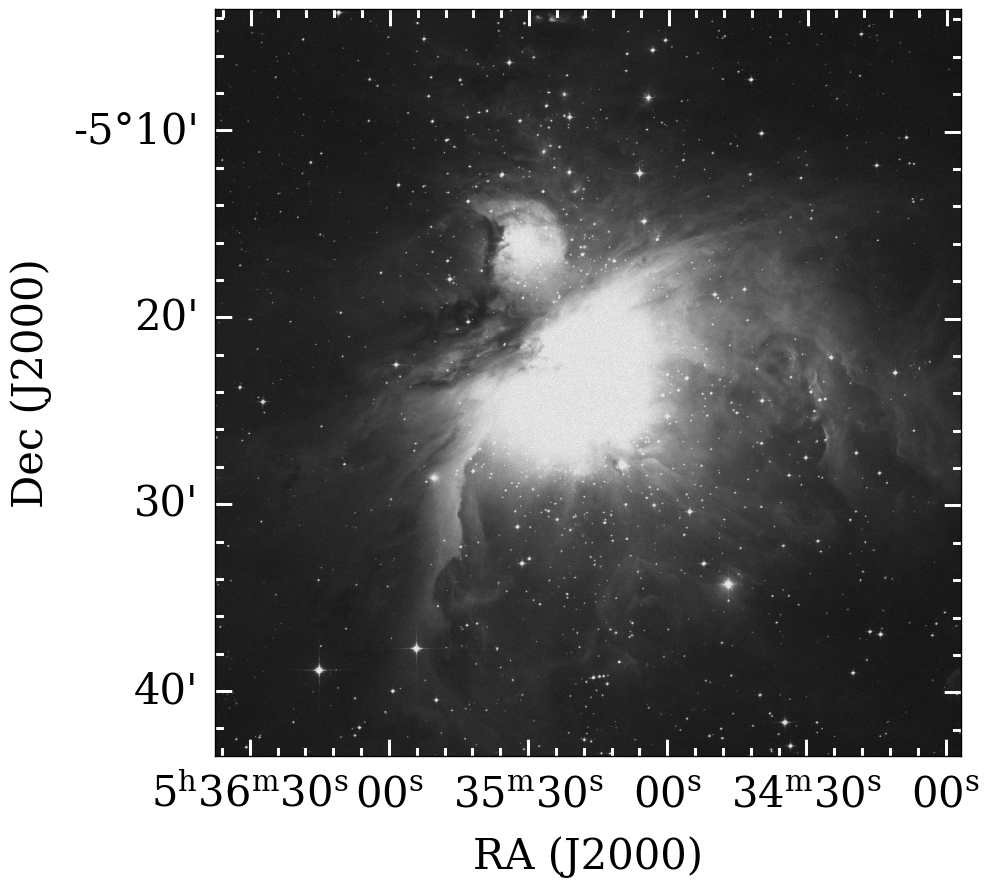

In [3]:
# create stacked array of data
stacked = np.zeros(shape=image_concat[0].shape)
for image in image_concat:
    stacked += image

# plot composite red+IR image
fig = aplpy.FITSFigure(fits_files[0], figsize=(10,10)) #, downsample=300) ###remove downsample=300 for final plot
# make ticks prettier
fig.ticks.set_tick_direction('in')
fig.ticks.set_linewidth(2)
fig.ticks.set_length(12, 0.5)
fig.show_grayscale(aspect='equal')

# Download the Gaia DR3 data for this region

## Select stars in the Orion Nebula

We will follow [Kounkel et al.
2022](https://academic.oup.com/mnras/article/517/1/161/6712721) (see
their Sec. 2.1). Note that they cross-match with a catalog of stars
from a different telescope (APOGEE).

For simplicity we will not do this, so our sample of stars is likely
more contaminated.

### Position of the center

In [4]:
RA_orion_center = 83.5 *u.deg
DEC_orion_center = -5*u.deg
Orion_center_kounkel = SkyCoord(ra=RA_orion_center, dec=DEC_orion_center, unit=(u.deg, u.deg), frame='icrs')

### Size of region

This is arbitrarily defined by the authors of that paper. Feel free to
change, they don't need to be the same!

In [5]:
width_orion = 1.5*u.deg
height_orion = 1.5*u.deg

### Projected bulk velocity of the cluster
*N.B.*: you could recompute this from the data without selecting based
on this criterion!

In [6]:
pm_RA_orion = 0.8*u.mas/u.yr
pm_DEC_orion = 2.8*u.mas/u.yr
tol_pm = 6*u.mas/u.yr # tolerance on how well the velocity of a star should match the bulk

## Query Gaia data

In [7]:
# check we use DR3
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
# read the data
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')
print(gaiadr3_table)

TAP Table name: gaiadr3.gaiadr3.gaia_source
Description: This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.
Num. columns: 152


In [8]:
# never download too many stars for testing, set to -1 for no limit, 1800 is enough to catch all the Gaia Data in Orion
Gaia.ROW_LIMIT = 18000
orion_kounkel = Gaia.query_object_async(coordinate=Orion_center_kounkel, width=width_orion, height=height_orion)

INFO: Query finished. [astroquery.utils.tap.core]


### Quality cuts
This ensure that we don't use foreground/background stars by checking
their parallax and their proper motion. The latter is not necessary in
principle, and could eliminate some of the fastest runaways. 

We also want to remove the data with bad quality

In [9]:
print("Initial number of stars", len(orion_kounkel['ra']))

Initial number of stars 17712


In [10]:
# Parallax cuts correspond to distances 285<=d<=500 pc
parallax_cut = ((orion_kounkel["parallax"]+orion_kounkel["parallax_error"])*u.mas >= 2*u.mas) & ((orion_kounkel["parallax"]-orion_kounkel["parallax_error"])*u.mas <= 3.5*u.mas)
print("Lost to parallax cut",  np.sum(1-parallax_cut))

Lost to parallax cut 12472


In [11]:
proper_motion_cut = ((orion_kounkel["pmra"]+orion_kounkel["pmra_error"])*u.mas/u.yr >= pm_RA_orion-tol_pm) &  ((orion_kounkel["pmdec"]-orion_kounkel["pmdec_error"])*u.mas/u.yr <= pm_DEC_orion+tol_pm)
print("Lost to proper motion cut", np.sum(1-proper_motion_cut))

Lost to proper motion cut 2988


In [12]:
# Renormalized unit weight error: if large indicates problems with the Data, see Lindegren et al. 2018
ruwe_cut = (orion_kounkel["ruwe"] < 1.4)
print("Lost to proper motion cut", np.sum(1-ruwe_cut))

Lost to proper motion cut 849


In [13]:
# Relative error in parallax: we require less than 10%, but Gaia provides 1/(relative error)
parallax_rel_err_cut = (orion_kounkel["parallax_over_error"] > 10)
print("Lost to proper motion cut", np.sum(1-parallax_rel_err_cut))

Lost to proper motion cut 11047


/home/math/Documents/Research/codes/anaconda3/envs/gaiadr3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


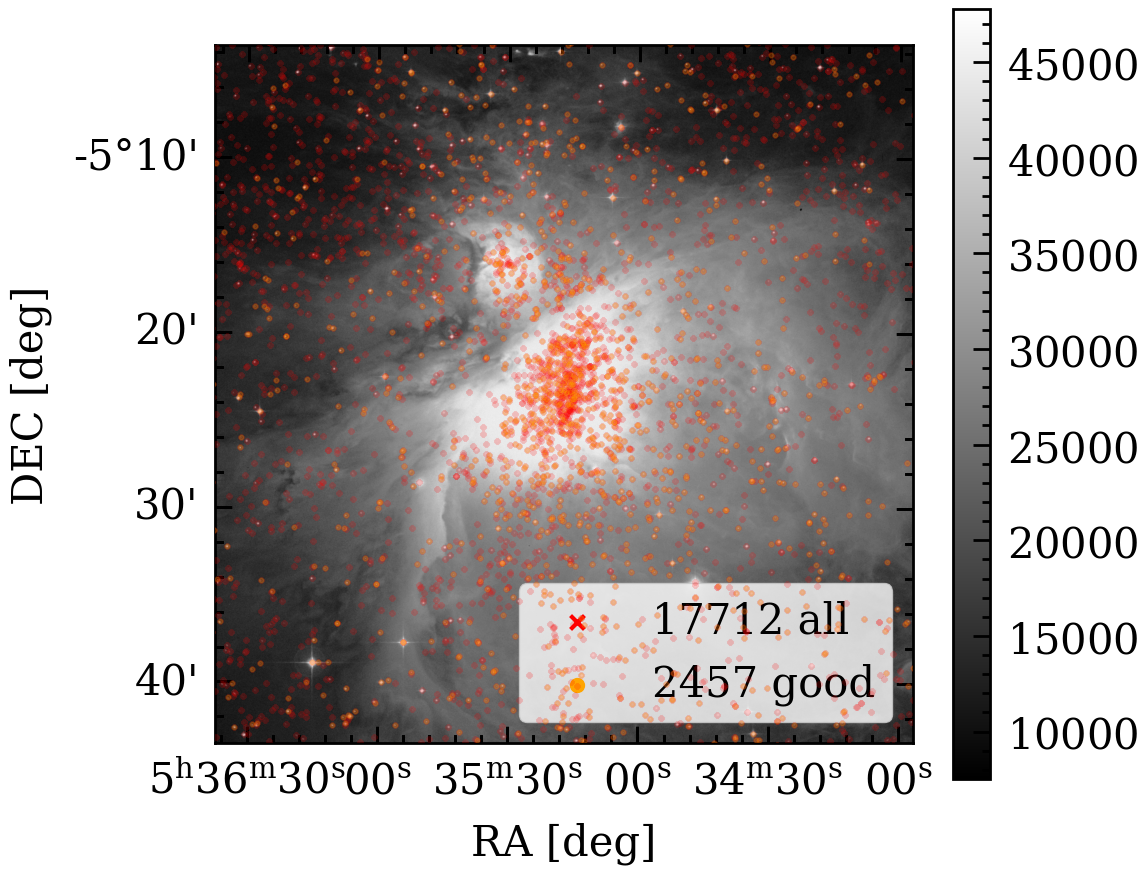

In [14]:
# now make the plot -- I wrote a function for plotting so you can pass to it a different star_sample
def plot_positions(stars_sample, stacked=None, wcs=None, index_good=None, fig_name=False):
    """
    Overplot over image the sample of stars provided

    Parameters
    ----------
    stars_sample: `<class 'astropy.table.table.Table'>` sample of stars
    index_good:   `np.array, dtype=bool` array of indexes for subsample
    stacked:      `np.array, dtype=float` 2D array contaning the stacked image
    wcs:          `<class 'astropy.wcs.wcs.WCS'>` world coordinate system for underlying image

    """
    # create figure and axes
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(100, 100)
    ax = fig.add_subplot(gs[:, :90], projection=wcs)
    cax = fig.add_subplot(gs[:, 95:])

    # read position data
    ra = stars_sample["ra"]
    dec = stars_sample["dec"]
    positions_icrs = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs') # in the Gaia frame
    # get position in underlying image coordinates
    x, y = wcs.all_world2pix(positions_icrs.ra.deg,positions_icrs.dec.deg, 0)
    # show underlying image
    p = ax.imshow(stacked, cmap='gray')
    # clip to composite image
    ax.set_xlim(0, len(stacked[0]))
    ax.set_ylim(0, len(stacked[1]))
    # add colorbar
    fig.colorbar(p, cax=cax)
    # add data
    ax.scatter(x, y, marker='x', c='r', s=10, zorder=10, alpha=0.2)
    ax.scatter(x[index_good], y[index_good], marker='o', c='orange', s=10, zorder=10, alpha=0.2)
    # hack to make symbols in legend bigger
    ax.scatter(np.nan, np.nan, marker='x', c='r', s=100, label=f"{len(x)}"+" all")
    ax.scatter(np.nan, np.nan, marker='o', c='orange', s=100, label=f"{len(x[index_good])}"+" good")
    ax.legend(frameon=True)
    ax.set_xlabel(r"RA [deg]")
    ax.set_ylabel(r"DEC [deg]")
    if fig_name:
        plt.savefig(fig_name)
        plt.close()
    else:
        plt.show()

# call to the function makes the plot, passing as index_good the cuts
index_good = (parallax_cut &
              proper_motion_cut &
              ruwe_cut &
              parallax_rel_err_cut)
plot_positions(orion_kounkel, stacked, wcs, index_good=index_good)

## Visualize velocities!

/home/math/Documents/Research/codes/anaconda3/envs/gaiadr3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


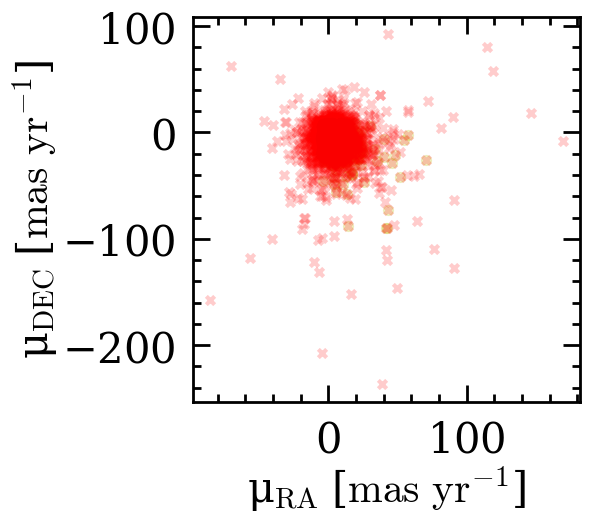

In [15]:
def plot_proper_motions(stars_sample, fig_name=None):
    pmra = stars_sample["pmra"]
    pmdec = stars_sample["pmdec"]
    pmra_err = stars_sample["pmra_error"]
    pmdec_err = stars_sample["pmdec_error"]
    # # check units!
    # print(pmra.unit)
    # print(pmra_err.unit)
    # print(pmdec.unit)
    # print(pmdec_err.unit)
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(100, 100)
    ax = fig.add_subplot(gs[:, :])
    ax.scatter(pmra, pmdec, c='r', marker='x', alpha=0.2, zorder=10)
    ax.scatter(pmra[index_good], pmdec[index_good], marker='o', c='y', alpha=0.2, s=50)
    ax.set_xlabel(r"$\mu_\mathrm{RA} \ [\mathrm{mas\ yr^{-1}}]$")
    ax.set_ylabel(r"$\mu_\mathrm{DEC} \ [\mathrm{mas\ yr^{-1}}]$")
    if fig_name:
        plt.savefig(fig_name)
        plt.close()
    else:
        plt.show()

plot_proper_motions(orion_kounkel)

/home/math/Documents/Research/codes/anaconda3/envs/gaiadr3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


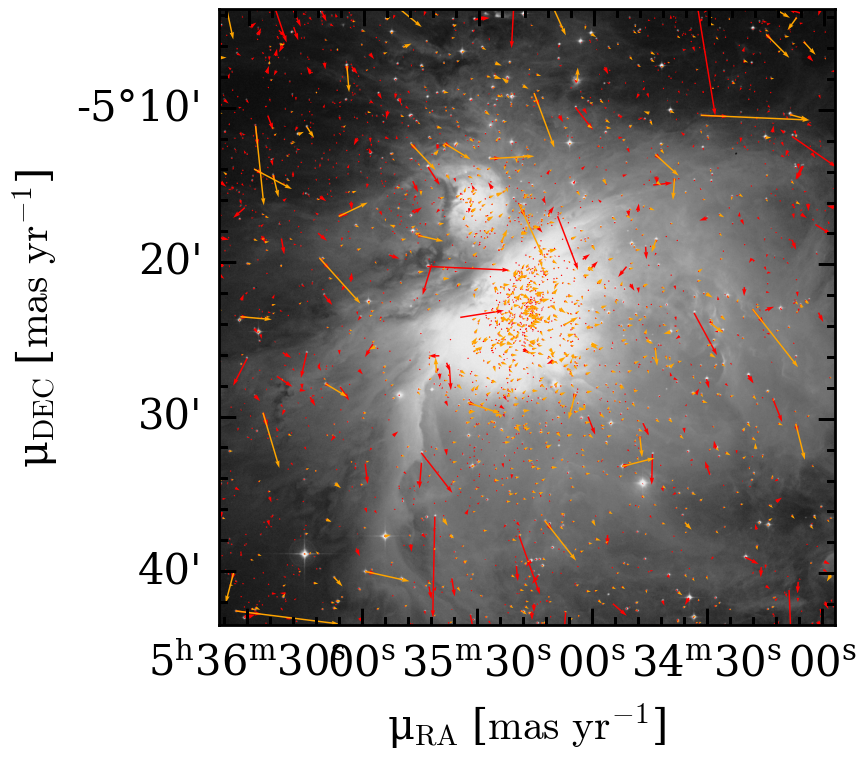

In [16]:
# visualize locations and velocities
def velocity_on_sky(stars_sample, wcs, index_good=None, fig_name=False):
    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(100, 100)
    ax = fig.add_subplot(gs[:, :], projection=wcs)
    ra = stars_sample["ra"]
    dec = stars_sample["dec"]
    pmra = stars_sample["pmra"]
    pmdec = stars_sample["pmdec"]
    positions_icrs = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs') # in the Gaia frame
    # get position in underlying image coordinates
    x, y = wcs.all_world2pix(positions_icrs.ra.deg,positions_icrs.dec.deg, 0)
    # show underlying image
    p = ax.imshow(stacked, cmap='gray')
    ax.quiver(x, y, pmra, pmdec, color='r')
    ax.quiver(x[index_good], y[index_good], pmra[index_good], pmdec[index_good], color='orange')
    # clip to composite image -- try commenting the next two lines to see all data!
    ax.set_xlim(0, len(stacked[0]))
    ax.set_ylim(0, len(stacked[1]))
    ax.set_xlabel(r"$\mu_\mathrm{RA} \ [\mathrm{mas\ yr^{-1}}]$")
    ax.set_ylabel(r"$\mu_\mathrm{DEC} \ [\mathrm{mas\ yr^{-1}}]$")
    if fig_name:
        plt.savefig(fig_name)
        plt.close()
    else:
        plt.show()


velocity_on_sky(orion_kounkel, wcs, index_good=index_good)
    

### Where in the sky are we looking?
See [astropy Skycoord docs](https://docs.astropy.org/en/stable/coordinates/skycoord.html)

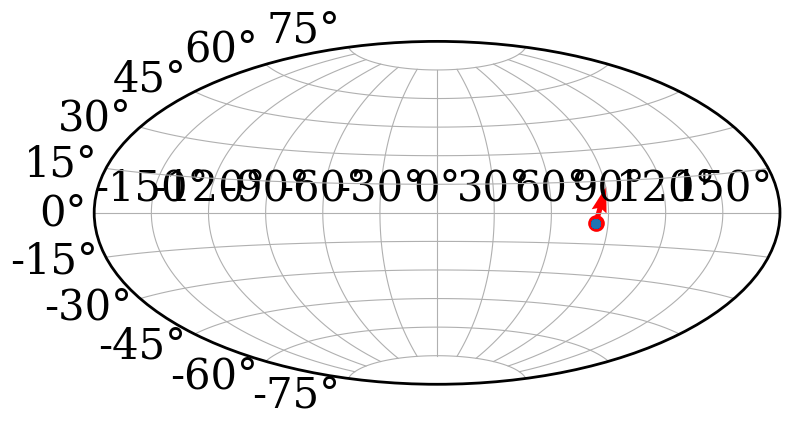

In [17]:
# see where in the Galaxy we are plotting things
fig = plt.figure(figsize=(8,20))
ax = fig.add_subplot(111, projection="aitoff")
ax.grid(True)


ra = orion_kounkel["ra"]
ra_err = orion_kounkel["ra_error"].to(u.degree)
dec = orion_kounkel["dec"]
dec_err = orion_kounkel["dec_error"].to(u.degree)

positions = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
ra_rad = positions.ra.wrap_at(180 * u.deg).radian
dec_rad = positions.dec.radian
     

ax.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
ax.plot(RA_orion_center.to(u.radian), DEC_orion_center.to(u.radian), markersize=10, zorder=0, c='r', marker='o')
ax.quiver(RA_orion_center.to(u.radian), DEC_orion_center.to(u.radian), pm_RA_orion.value, pm_DEC_orion.value, color='r')

Note that so far we have not dealt with uncertainties. Gaia provides
all the data to fold these in the data analysis.

# Further exercises

*Suggestion*: try to visualize the disk structure of the Galaxy with a
similar plot (N.B.: may require downloading a large chunck of the DR3
catalog, remember to update `Gaia.ROW_LIMIT`)

In [18]:
# this is a new code cell -- type python code and execute with shit+Enter